Tutorial 4: Data and Models
===========================

Up to now, we've used used the `Aggregator` to load and inspect the `Result` and `Samples` of 3 model-fits.

In this tutorial, we'll look at how write Python generators which use the `Aggregator` to inspect, interpret and plot
the results of the model-fit, including fitting and plotting different models to our data.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


We begin by loading the database via the `.sqlite` file as we did in the previous tutorial. 

In [2]:
from autofit.database.aggregator import Aggregator

agg = Aggregator.from_database(
    path.join("output", "howtofit", "database", "database.sqlite"),
)

We'll reuse the `plot_line` function of previous tutorials, however it now displays to the notebook as opposed to
outputting the results to a .png file.

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def plot_line(xvalues, line, title=None, ylabel=None, errors=None, color="k"):
    plt.errorbar(
        x=xvalues, y=line, yerr=errors, color=color, ecolor="k", elinewidth=1, capsize=2
    )
    plt.title(title)
    plt.xlabel("x value of profile")
    plt.ylabel(ylabel)
    plt.show()
    plt.clf()


We can use the `Aggregator` to load a generator of every fit`s data, by changing the `output` attribute to the 
`data` attribute at the end of the aggregator.

Note that in the `Analysis` class of tutorial 1, we specified that the `data` object would be saved to hard-disc using
the `save_attributes_for_aggregator` method, so that the `Aggregator` can load it.

In [4]:
data_gen = agg.values("data")
print("Datas:")
print(list(data_gen), "\n")

Datas:
[array([-1.26394379e-02, -4.79400015e-02,  2.35187148e-02, -3.72099891e-03,
       -2.38611526e-02, -1.67891107e-02,  8.67685651e-02, -3.15219661e-02,
       -4.49320451e-02,  1.60149953e-02, -5.20249048e-02,  6.13744114e-03,
        2.90172747e-03, -1.62311431e-02, -2.98516037e-02,  2.51542338e-02,
       -4.39530643e-02, -2.78368937e-02,  2.34264504e-02,  4.26457373e-02,
       -7.20061281e-03, -2.80005408e-02,  2.74776745e-02,  8.90954879e-02,
        2.28401426e-02, -2.30452070e-04,  2.01361174e-02, -4.75765411e-02,
        5.06418583e-04, -1.21810434e-02, -3.26933725e-02, -8.85322837e-03,
        1.87314204e-02, -4.33979492e-02, -1.10732674e-03, -5.00320820e-02,
        3.48527671e-03,  5.34326197e-02, -7.10349639e-02,  3.96437108e-02,
        2.07038921e-02, -8.36326327e-02,  9.01160761e-03, -6.56096647e-02,
       -1.04239220e-02,  2.97600169e-02,  3.51121005e-02,  1.13201149e-01,
        1.38263064e+00,  6.09791012e+00,  1.00005869e+01,  6.08913585e+00,
        1.3667439

We can plot the `data` using the `plot_line` method.

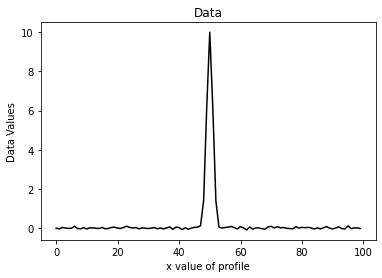

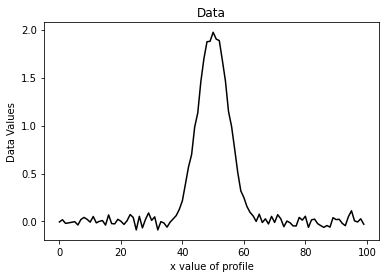

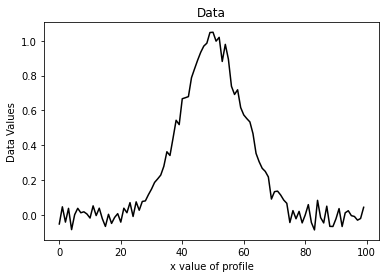

<Figure size 432x288 with 0 Axes>

In [5]:
for data in agg.values("data"):

    plot_line(
        xvalues=np.arange(data.shape[0]),
        line=data,
        title="Data",
        ylabel="Data Values",
        color="k",
    )

We can repeat the same trick to get the `noise_map` of every fit.

In [6]:
noise_map_gen = agg.values("noise_map")
print("Noise-Maps:")
print(list(noise_map_gen), "\n")

Noise-Maps:
[array([0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04]), array([0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04

The `info` dictionary we input into the `NonLinearSearch` is also available.

In [7]:
for info in agg.values("info"):
    print(info)

{'date_of_observation': '01-02-18', 'exposure_time': 1000.0}
{'date_of_observation': '01-02-18', 'exposure_time': 1000.0}
{'date_of_observation': '01-02-18', 'exposure_time': 1000.0}


We're going to refit each dataset with the `max_log_likelihood_instance` of each model-fit and plot the residuals.

(If you are unsure what the `zip` is doing below, it essentially combines the `data_gen`, `noise_map_gen` and
`samples_gen` into one list such that we can iterate over them simultaneously).

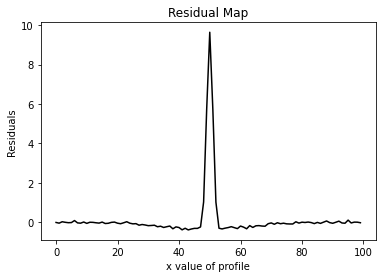

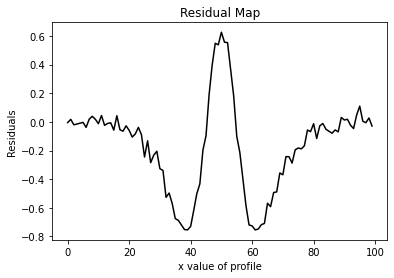

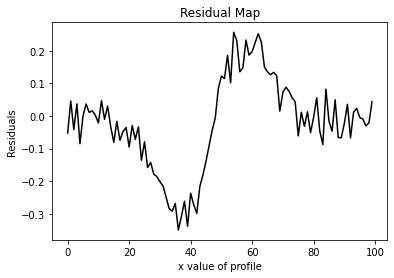

<Figure size 432x288 with 0 Axes>

In [8]:
samples_gen = agg.values("samples")
data_gen = agg.values("data")
noise_map_gen = agg.values("noise_map")

for data, noise_map, samples in zip(data_gen, noise_map_gen, samples_gen):

    instance = samples.max_log_likelihood_instance

    xvalues = np.arange(data.shape[0])

    model_data = sum(
        [profile.profile_from_xvalues(xvalues=xvalues) for profile in instance]
    )

    residual_map = data - model_data

    plot_line(
        xvalues=xvalues,
        line=residual_map,
        title="Residual Map",
        ylabel="Residuals",
        color="k",
    )

There is a problem with how we plotted the residuals above, can you guess what it is?

We used lists! If we had fit a large sample of data, the above object would store the data of all objects 
simultaneously in memory on our hard-disk, likely crashing our laptop! To avoid this, we must write functions that 
manipulate the `Aggregator` generators as generators themselves. Below is an example function that performs the same 
task as above.

In [9]:
def plot_residuals_from_agg_obj(agg_obj):

    data = agg_obj.data
    noise_map = agg_obj.noise_map
    samples = agg_obj.samples

    instance = samples.max_log_likelihood_instance

    xvalues = np.arange(data.shape[0])

    model_data = sum(
        [profile.profile_from_xvalues(xvalues=xvalues) for profile in instance]
    )

    residual_map = data - model_data

    plot_line(
        xvalues=xvalues,
        line=residual_map,
        title="Residual Map",
        ylabel="Residuals",
        color="k",
    )


To manipulate this function as a generator using the `Aggregator`, we apply it to the `Aggregator`'s `map` function.

In [10]:
pass
# plot_residuals_gen = agg.map(func=plot_residuals_from_agg_obj)

Lets get the `max_log_likelihood_instance`s, as we did in tutorial 3.

In [11]:
pass
# instances = [samps.max_log_likelihood_instance for samps in agg.values("samples")]

Okay, we want to inspect the fit of each `max_log_likelihood_instance`. To do this, we reperform each fit.

First, we need to create the `model_data` of every `max_log_likelihood_instance`. Lets begin by creating a list 
of profiles of every model-fit.